In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')

%matplotlib inline

This data was collected from `ClimaCell API`. ClimaCell is an American weather technology company that repurposes wireless communication networks for advanced weather forecasting. Details about the columns in data:
- **date_time**: IST date and time
- **date**: seperated dates from datetime stamp
- **time**: seperated times from datetime stamp
- **irradiation**: solar irradiance in (W/m^2) at 5 minutes of interval
- **ambient_temp**: ambient temperature at 5 minutes of interval
- **wind_speed**: speed of wind at 5 minutes of interval

Target: 
    Prediction of future solar irradiance values (W/m^2)

Performance Metrics: 
    r2, RMSE, Normalized RMSE

In [2]:
climate = pd.read_csv('../climacell_data_formodel.csv', index_col='date_time', parse_dates=['date_time'])
climate.drop(columns=['date', 'time'], inplace=True)
climate['month'] = climate.index.month
climate['day'] = climate.index.day
climate['minute'] = climate.index.minute
climate.head()

,irradiance,ambient_temp,wind_speed,month,day,minute
date_time,,,,,,
2020-08-20 06:05:00+05:30,0,28.58,6.33,8,20,5
2020-08-20 06:10:00+05:30,0,28.57,6.26,8,20,10
2020-08-20 06:15:00+05:30,0,28.57,6.18,8,20,15
2020-08-20 06:20:00+05:30,0,28.56,6.11,8,20,20
2020-08-20 06:25:00+05:30,0,28.56,6.03,8,20,25


In [3]:
climate.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2952 entries, 2020-08-20 06:05:00+05:30 to 2020-10-20 12:00:00+05:30
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   irradiance    2952 non-null   int64  
 1   ambient_temp  2952 non-null   float64
 2   wind_speed    2952 non-null   float64
 3   month         2952 non-null   int64  
 4   day           2952 non-null   int64  
 5   minute        2952 non-null   int64  
dtypes: float64(2), int64(4)
memory usage: 161.4 KB


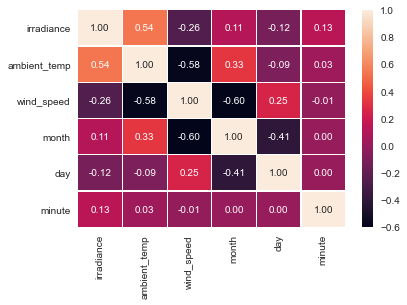

In [4]:
sns.heatmap(climate.corr(), annot=True, fmt='.2f', linewidths=0.2)
plt.show()

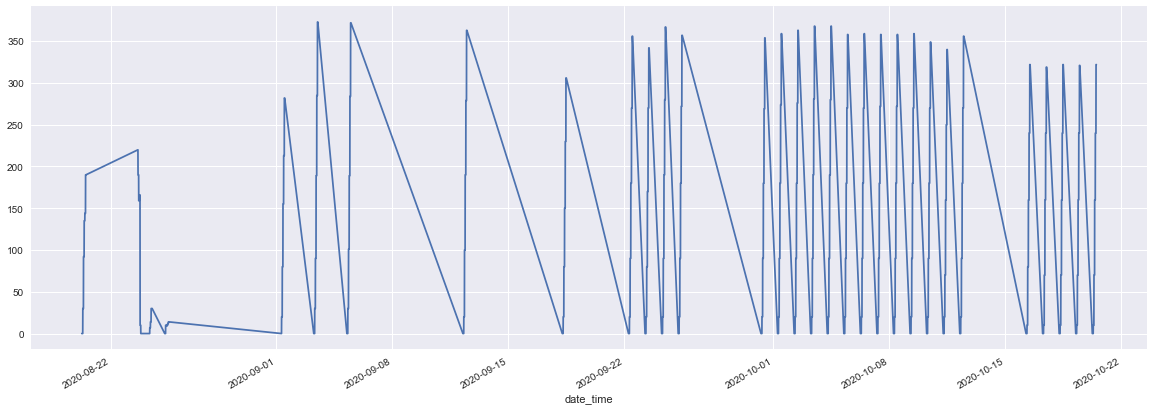

In [5]:
plt.figure(figsize=(20,7))
climate['irradiance'].plot()
plt.show()

Let's check the stationary property of the series using `Dickey fuller` test.

In [6]:
from statsmodels.tsa.stattools import adfuller

# H0 = Null hypothesis in ADF test (given time series is non-stationary)
# H1 = Alternate hypothesis in ADF test (given time series in stationary)
# if ADF stat < critical val then reject H0 else accept H0

def is_stationary(series):
    X = series.values
    result = adfuller(X)
    print('ADF statistic: %f' %result[0])
    print('p value: %f' %result[1]) # result[2] is Number of Lags and result[3] number of observations used
    print('Critical Values:')

    for key, val in result[4].items():
        print('\t%s: %.3f' %(key, val))

    if result[0] < result[4]["5%"]:
        print('Reject H0 - Time series is Stationary')
    else:
        print('Accept H0 - Time series is Non-Stationary')

In [7]:
is_stationary(climate['irradiance'])

ADF statistic: -14.867775
p value: 0.000000
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
Reject H0 - Time series is Stationary


Awesome!! it was stationary in nature.

In [8]:
dataset = climate['irradiance'].copy(deep=True)
dataset = dataset.values.reshape(-1, 1)

In [9]:
import math
from tensorflow import keras
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Bidirectional, LSTM, GRU
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

In [10]:
from sklearn.metrics import r2_score, mean_squared_error
from skimage.metrics import normalized_root_mse

def model_performance_metrics(pred, actual):
    '''
    Takes the predicted and actual values and return r2_score, rmse, and normalized rmse
    '''
    #r2_score
    r2 = r2_score(actual, pred)  # 1-(SSR/SST) where SST-sum of square of deviation and SSR-sum of square of error
    #root mean squared error
    rmse = np.sqrt(mean_squared_error(actual, pred))
    #normalized root mean squared error
    nrmse = normalized_root_mse(actual, pred)

    print('R2 score: %f' %r2)
    print('RMSE: %f' %rmse)
    print('Normalized RMSE: %f' %nrmse)

    return r2, rmse, nrmse

In [11]:
# normalize the dataset
scaler = MinMaxScaler()
dataset = scaler.fit_transform(dataset)

# split into train and test sets
train_size = int(len(dataset) * 0.7)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

2066 886


In [12]:
# convert an array of value into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [13]:
def MLP():
    '''
    Multilayer perceptron, Inputs: training features and label
    '''
    model = Sequential([
    Dense(64, activation='relu', input_shape=(1, look_back)),
    Dense(64, activation='relu'),
    Dense(1)
  ])
  
    model.compile(loss='mean_squared_error', optimizer='adam')
    # model.fit(trainX, trainY, epochs=100, batch_size=8, verbose=2)
    return model

def STLSTM():
    '''
    Stacked LSTM, Inputs: training features and label
    '''
    model = Sequential()
    model.add(LSTM(64, activation='relu', return_sequences=True, input_shape=(look_back, 1)))
    model.add(LSTM(64, activation='relu'))
    model.add(Dense(1))
    
    model.compile(loss='mse', optimizer='adam', metrics=['mae', 'mse'])
    # model.fit(trainX, trainY, epochs=100, batch_size=8, verbose=2)
    return model

def GRU_model():
    '''
    Gated Recurrent Units, Inputs: training data
    '''
    model = Sequential()
    model.add(GRU(64, activation='relu', return_sequences=True, input_shape=(look_back, 1)))
    model.add(Dropout(0.2))
    model.add(GRU(64, activation='relu'))
    model.add(Dense(1))
    
    model.compile(loss='mse', optimizer='adam', metrics=['mae', 'mse'])
    # model.fit(trainX, trainY, epochs=100, batch_size=8, verbose=2)
    return model

def BILSTM():
    '''
    Bidirectional LSTM, Inputs: trainig data
    '''
    model = Sequential()
    model.add(Bidirectional(LSTM(64, activation='relu'), input_shape=(look_back, 1)))
    model.add(Dense(1))

    model.compile(loss='mse', optimizer='adam', metrics=['mae', 'mse'])
    # model.fit(trainX, trainY, epochs=100, batch_size=8, verbose=2)
    return model

In [14]:
# reshape into X=t and Y=t+1
def train_test_split(look_back):
    trainX, trainY = create_dataset(train, look_back)
    testX, testY = create_dataset(test, look_back)
    return trainX, trainY, testX, testY

def reshaping(trainX, testX, model_type='mlp'):
    if model_type =='mlp':
        trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
        testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
    else:
        # reshape input to be [samples, time steps (loop_back), features]
        trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
        testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))
    return trainX, testX

In [15]:
def performance(model, trainX, trainY, testX, testY, model_type='mlp'):
    '''
    This function takes the model and the train_test_split data, prints the performance on training and testing set
    and returns the prediction.
    '''
    # making prediction
    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX)
    
    if model_type == 'mlp':
        trainPredict = trainPredict.reshape(-1,1)
        testPredict = testPredict.reshape(-1,1)
    
    # transform back to original form
    trainPredict = scaler.inverse_transform(trainPredict)
    trainY = scaler.inverse_transform(trainY.reshape(-1,1))
    testPredict = scaler.inverse_transform(testPredict)
    testY = scaler.inverse_transform(testY.reshape(-1,1))

    print('Training score:')
    model_performance_metrics(trainY, trainPredict)
    print('\nTest score:')
    model_performance_metrics(testY, testPredict)

    return trainPredict, testPredict

def make_plot(trainPredict, testPredict):
    '''
    This function plot the actual and predicted irradiance value from the model.
    '''
    # shift train predictions for plotting
    trainPredictPlot = np.empty_like(dataset)
    trainPredictPlot[:, :] = np.nan
    trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
    # shift test predictions for plotting
    testPredictPlot = np.empty_like(dataset)
    testPredictPlot[:, :] = np.nan
    testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
    # plot baseline and predictions
    plt.figure(figsize=(20, 7))
    plt.plot(scaler.inverse_transform(dataset), label='Actual')
    plt.plot(trainPredictPlot, label='Train predict')
    plt.plot(testPredictPlot, label='Test predict')
    plt.legend()
    plt.show()

## MLP model

In [16]:
look_back = 100
trainX, trainY, testX, testY = train_test_split(look_back)
trainX, testX = reshaping(trainX, testX, 'mlp')

In [17]:
mlp = MLP()
mlp.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1, 64)             6464      
_________________________________________________________________
dense_1 (Dense)              (None, 1, 64)             4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1, 1)              65        
Total params: 10,689
Trainable params: 10,689
Non-trainable params: 0
_________________________________________________________________


In [18]:
mlp.fit(trainX, trainY, epochs=50, batch_size=16, verbose=1)

Epoch 1/50
123/123 [==============================] - 0s 584us/step - loss: 0.0173
Epoch 2/50
123/123 [==============================] - 0s 568us/step - loss: 0.0029
Epoch 3/50
123/123 [==============================] - 0s 673us/step - loss: 0.0016
Epoch 4/50
123/123 [==============================] - 0s 624us/step - loss: 0.0013
Epoch 5/50
123/123 [==============================] - 0s 673us/step - loss: 0.0014
Epoch 6/50
123/123 [==============================] - 0s 584us/step - loss: 0.0011
Epoch 7/50
123/123 [==============================] - 0s 641us/step - loss: 9.0354e-04
Epoch 8/50
123/123 [==============================] - 0s 576us/step - loss: 0.0010
Epoch 9/50
123/123 [==============================] - 0s 592us/step - loss: 9.9370e-04
Epoch 10/50
123/123 [==============================] - 0s 551us/step - loss: 8.5527e-04
Epoch 11/50
123/123 [==============================] - 0s 551us/step - loss: 6.9962e-04
Epoch 12/50
123/123 [==============================] - 0s 559us/step 

In [19]:
trainPredict, testPredict = performance(mlp, trainX, trainY, testX, testY)

Training score:
R2 score: 0.995425
RMSE: 7.996589
Normalized RMSE: 0.047883

Test score:
R2 score: 0.995813
RMSE: 7.446108
Normalized RMSE: 0.043925


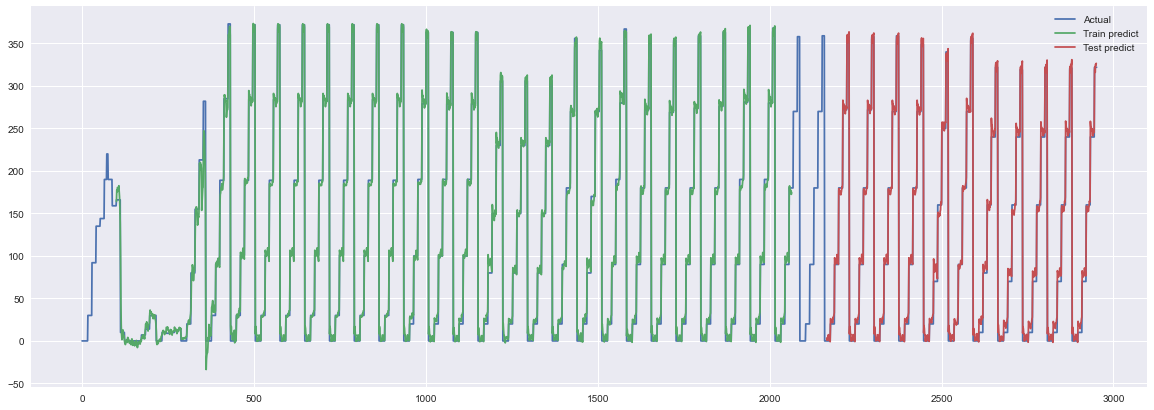

In [20]:
make_plot(trainPredict, testPredict)

## Stacked LSTM model

In [21]:
look_back = 100
trainX, trainY, testX, testY= train_test_split(look_back)
trainX, testX = reshaping(trainX, testX, 'stlstm')

In [22]:
stlstm = STLSTM()
stlstm.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 64)           16896     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 49,985
Trainable params: 49,985
Non-trainable params: 0
_________________________________________________________________


In [23]:
stlstm.fit(trainX, trainY, epochs=50, batch_size=16, verbose=1)

Epoch 1/50
123/123 [==============================] - 5s 37ms/step - loss: 0.0493 - mae: 0.1507 - mse: 0.0493
Epoch 2/50
123/123 [==============================] - 5s 38ms/step - loss: 0.0214 - mae: 0.0896 - mse: 0.0214
Epoch 3/50
123/123 [==============================] - 5s 39ms/step - loss: 0.0180 - mae: 0.0818 - mse: 0.0180
Epoch 4/50
123/123 [==============================] - 5s 41ms/step - loss: 0.0170 - mae: 0.0773 - mse: 0.0170
Epoch 5/50
123/123 [==============================] - 4s 36ms/step - loss: 0.0140 - mae: 0.0689 - mse: 0.0140
Epoch 6/50
123/123 [==============================] - 4s 36ms/step - loss: 0.0141 - mae: 0.0684 - mse: 0.0141
Epoch 7/50
123/123 [==============================] - 4s 36ms/step - loss: 0.0137 - mae: 0.0634 - mse: 0.0137
Epoch 8/50
123/123 [==============================] - 4s 36ms/step - loss: 0.0132 - mae: 0.0635 - mse: 0.0132
Epoch 9/50
123/123 [==============================] - 4s 36ms/step - loss: 0.0134 - mae: 0.0606 - mse: 0.0134
Epoch 10/5

In [24]:
trainPredict, testPredict = performance(stlstm, trainX, trainY, testX, testY, 'stlstm')

Training score:
R2 score: 0.980818
RMSE: 16.049989
Normalized RMSE: 0.099397

Test score:
R2 score: 0.978615
RMSE: 16.350842
Normalized RMSE: 0.100797


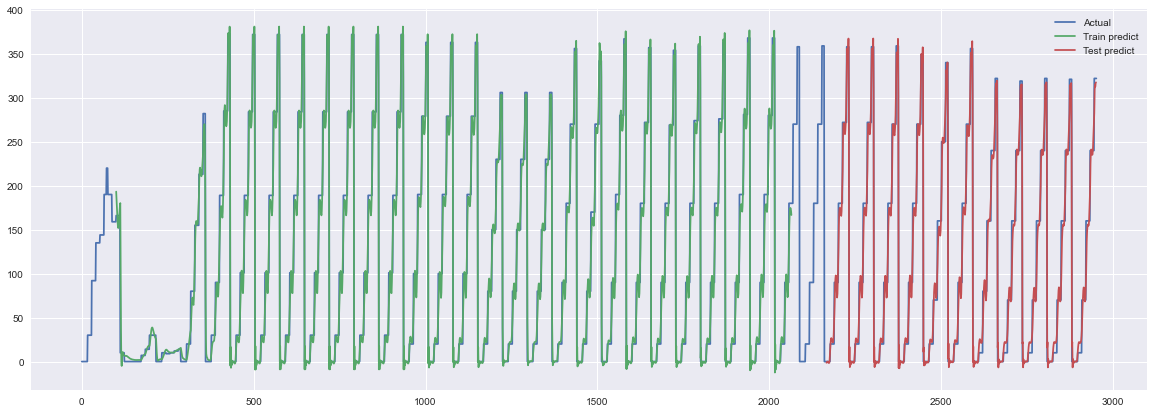

In [25]:
make_plot(trainPredict, testPredict)

## Gated Recurrent Units model

In [26]:
look_back = 100
trainX, trainY, testX, testY= train_test_split(look_back)
trainX, testX = reshaping(trainX, testX, 'gru')

In [27]:
gru = GRU_model()
gru.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 100, 64)           12864     
_________________________________________________________________
dropout (Dropout)            (None, 100, 64)           0         
_________________________________________________________________
gru_1 (GRU)                  (None, 64)                24960     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 37,889
Trainable params: 37,889
Non-trainable params: 0
_________________________________________________________________


In [28]:
gru.fit(trainX, trainY, epochs=50, batch_size=16, verbose=1)

Epoch 1/50
123/123 [==============================] - 4s 35ms/step - loss: 0.0371 - mae: 0.1124 - mse: 0.0371
Epoch 2/50
123/123 [==============================] - 4s 35ms/step - loss: 0.0154 - mae: 0.0642 - mse: 0.0154
Epoch 3/50
123/123 [==============================] - 4s 35ms/step - loss: 0.0147 - mae: 0.0603 - mse: 0.0147
Epoch 4/50
123/123 [==============================] - 4s 35ms/step - loss: 0.0146 - mae: 0.0588 - mse: 0.0146
Epoch 5/50
123/123 [==============================] - 4s 35ms/step - loss: 0.0147 - mae: 0.0615 - mse: 0.0147
Epoch 6/50
123/123 [==============================] - 4s 35ms/step - loss: 0.0141 - mae: 0.0586 - mse: 0.0141
Epoch 7/50
123/123 [==============================] - 4s 35ms/step - loss: 0.0145 - mae: 0.0599 - mse: 0.0145
Epoch 8/50
123/123 [==============================] - 5s 38ms/step - loss: 0.0137 - mae: 0.0570 - mse: 0.0137
Epoch 9/50
123/123 [==============================] - 5s 39ms/step - loss: 0.0135 - mae: 0.0565 - mse: 0.0135
Epoch 10/5

In [29]:
trainPredict, testPredict = performance(gru, trainX, trainY, testX, testY, 'gru')

Training score:
R2 score: 0.979597
RMSE: 17.067696
Normalized RMSE: 0.099547

Test score:
R2 score: 0.981499
RMSE: 15.949093
Normalized RMSE: 0.092500


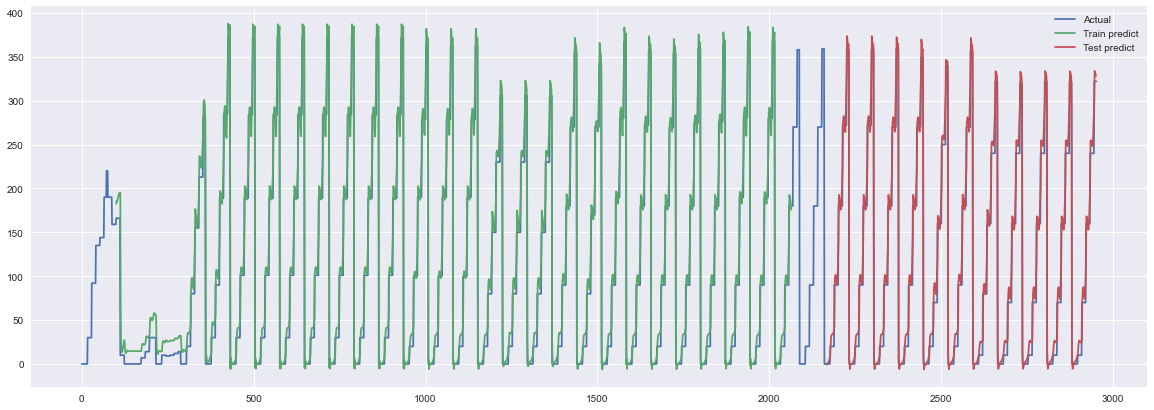

In [30]:
make_plot(trainPredict, testPredict)

## Bidirectional LSTM model

In [31]:
look_back = 100
trainX, trainY, testX, testY= train_test_split(look_back)
trainX, testX = reshaping(trainX, testX, 'bilstm')

In [32]:
bilstm = BILSTM()
bilstm.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 128)               33792     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 129       
Total params: 33,921
Trainable params: 33,921
Non-trainable params: 0
_________________________________________________________________


In [34]:
bilstm.fit(trainX, trainY, epochs=50, batch_size=16, verbose=1)

Epoch 1/50
123/123 [==============================] - 3s 22ms/step - loss: 0.0047 - mae: 0.0357 - mse: 0.0047
Epoch 2/50
123/123 [==============================] - 3s 22ms/step - loss: 0.0057 - mae: 0.0384 - mse: 0.0057
Epoch 3/50
123/123 [==============================] - 3s 24ms/step - loss: 0.0038 - mae: 0.0338 - mse: 0.0038
Epoch 4/50
123/123 [==============================] - 3s 23ms/step - loss: 0.0046 - mae: 0.0348 - mse: 0.0046
Epoch 5/50
123/123 [==============================] - 3s 23ms/step - loss: 0.0034 - mae: 0.0320 - mse: 0.0034
Epoch 6/50
123/123 [==============================] - 3s 22ms/step - loss: 0.0033 - mae: 0.0302 - mse: 0.0033
Epoch 7/50
123/123 [==============================] - 3s 22ms/step - loss: 0.0036 - mae: 0.0310 - mse: 0.0036
Epoch 8/50
123/123 [==============================] - 3s 23ms/step - loss: 0.0025 - mae: 0.0284 - mse: 0.0025
Epoch 9/50
123/123 [==============================] - 3s 22ms/step - loss: 0.0026 - mae: 0.0277 - mse: 0.0026
Epoch 10/5

In [35]:
trainPredict, testPredict = performance(bilstm, trainX, trainY, testX, testY, 'bilstm')

Training score:
R2 score: 0.994818
RMSE: 8.662527
Normalized RMSE: 0.051966

Test score:
R2 score: 0.995846
RMSE: 7.519985
Normalized RMSE: 0.044988


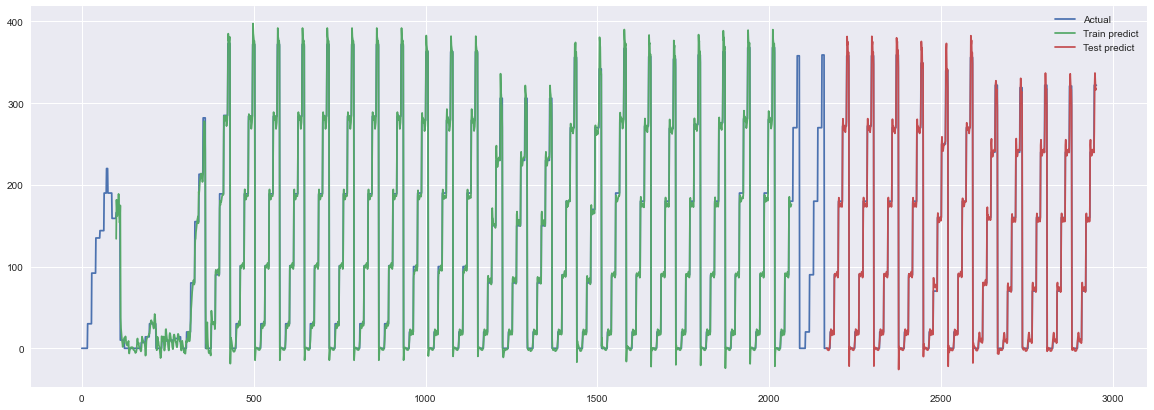

In [36]:
make_plot(trainPredict, testPredict)

## Future prediction

Above we can see the performances of MLP, Stacked LSTM, GRU, and Bidirectional LSTM from which MLP and Bidirectional LSTM perform better than others.

Below, let's see the next or Future prediction of solar irradiance value using Bidirectional LSTTM model.

In [86]:
x_input = dataset[2852:].reshape(1, -1)
temp_input = list(x_input)[0].tolist()

In [87]:
# Next 300 irradiance value prediction and saved into the output list
output = []

i = 0
while(i<300):
    if len(temp_input) > 100:
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, look_back, 1))
        y_hat = bilstm.predict(x_input, verbose=0)
        # print("{} future value: {}".format(i, y_hat[0]))
        
        temp_input.extend(y_hat[0].tolist())
        temp_input = temp_input[1:]
        output.extend(y_hat.tolist())
        i = i+1
    else:
        x_input = x_input.reshape((1, look_back, 1))
        y_hat = bilstm.predict(x_input, verbose=0)
        temp_input.extend(y_hat[0].tolist())
        output.extend(y_hat.tolist())
        i = i+1

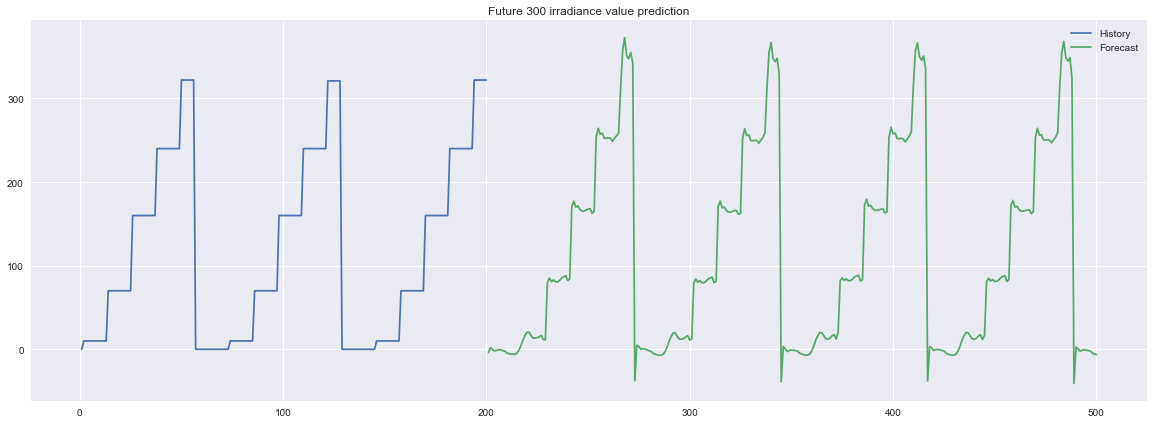

In [88]:
# Plot the future irradiance values
plt.figure(figsize=(20,7))
plt.title('Future 300 irradiance value prediction')
plt.plot(np.arange(1, 201), scaler.inverse_transform(dataset[2752:]), label='History')
plt.plot(np.arange(201,501), scaler.inverse_transform(output), label='Forecast')
plt.legend()
plt.show()

This is the future prediction of solar irradiance using the Bidirectional LSTM model.